In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Load dan Persiapkan Data
print("=== Loading and Preparing Data ===")
df = pd.read_csv('../data/processed/stroke_data_final.csv')
X = df.drop('stroke', axis=1)
y = df['stroke']

# Pisahkan data training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

=== Loading and Preparing Data ===
Training set shape: (1166, 21)
Testing set shape: (292, 21)



=== Model Training and Evaluation ===

=== Training Logistic Regression ===

Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       195
           1       0.66      0.80      0.73        97

    accuracy                           0.80       292
   macro avg       0.78      0.80      0.78       292
weighted avg       0.81      0.80      0.80       292



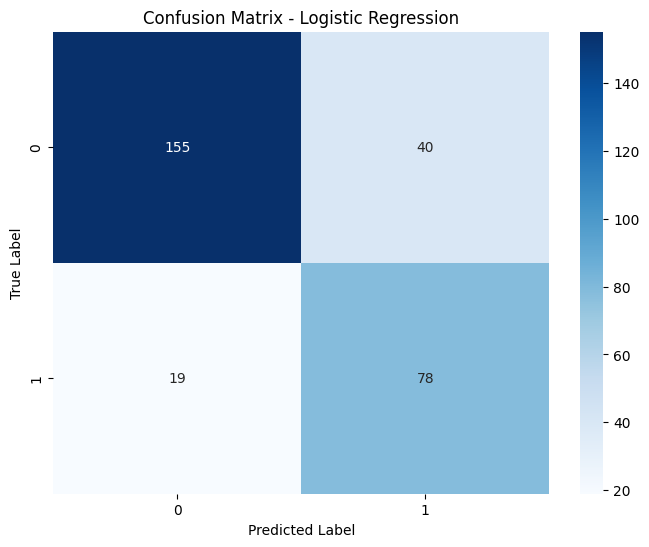

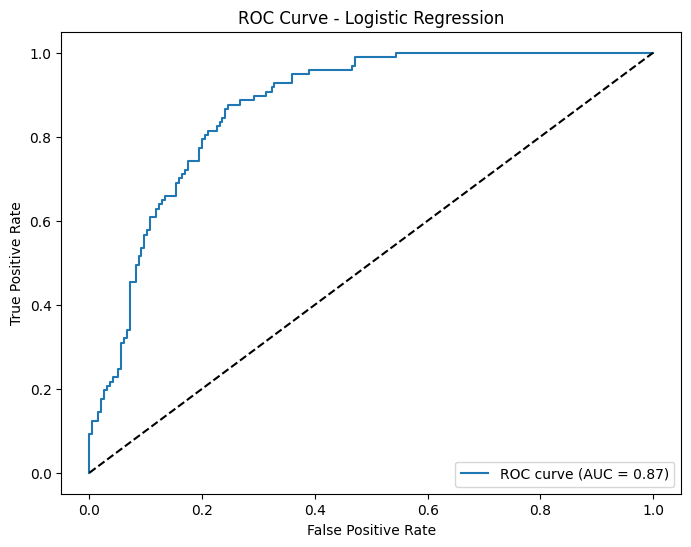


Cross-validation ROC-AUC scores: [0.89488823 0.86588412 0.87766749 0.78585608 0.8566584 ]
Average CV ROC-AUC: 0.856 (+/- 0.075)

=== Training Random Forest ===

Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       195
           1       0.78      0.78      0.78        97

    accuracy                           0.86       292
   macro avg       0.84      0.84      0.84       292
weighted avg       0.86      0.86      0.86       292



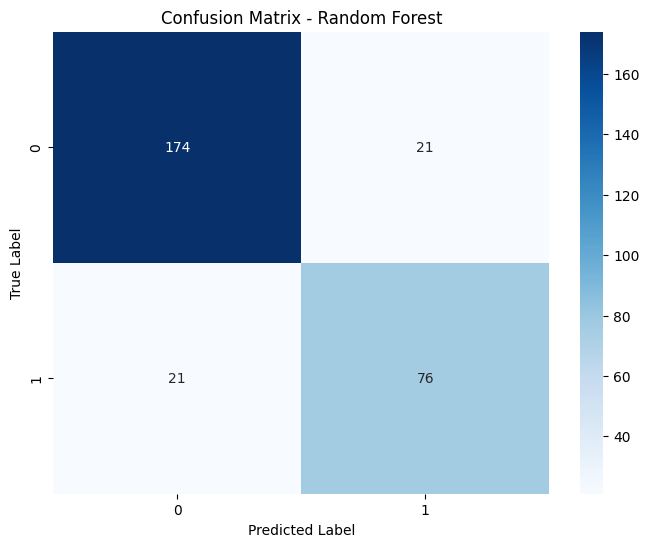

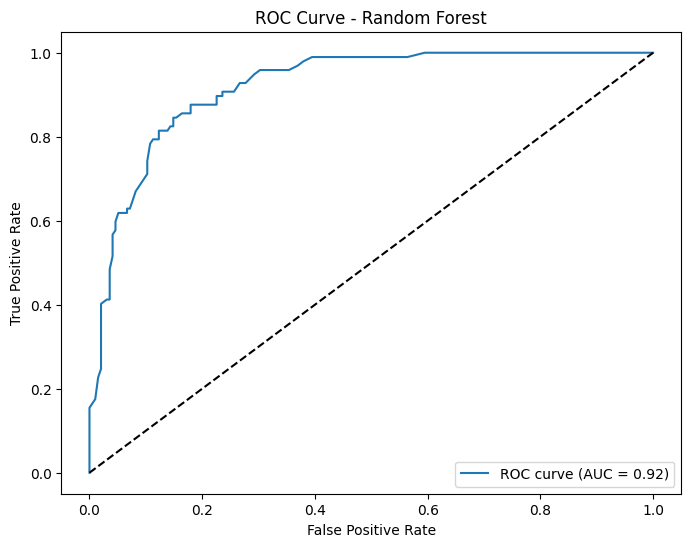


Cross-validation ROC-AUC scores: [0.90774984 0.90526141 0.88531844 0.81679074 0.88271299]
Average CV ROC-AUC: 0.880 (+/- 0.066)

=== Training XGBoost ===

XGBoost Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       195
           1       0.72      0.77      0.75        97

    accuracy                           0.83       292
   macro avg       0.80      0.81      0.81       292
weighted avg       0.83      0.83      0.83       292



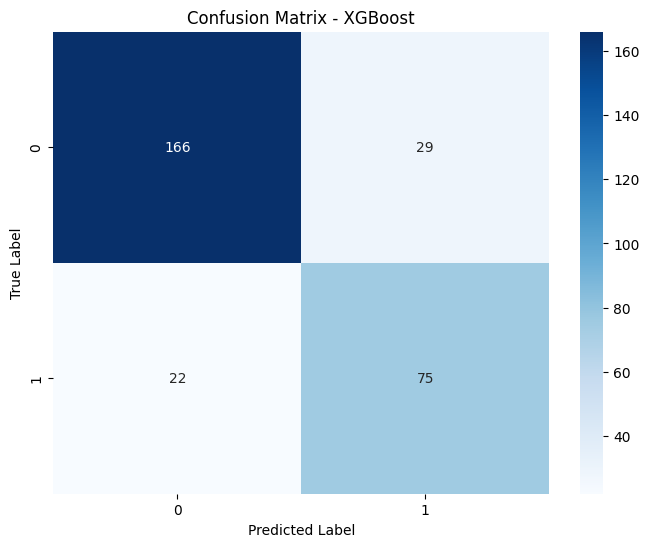

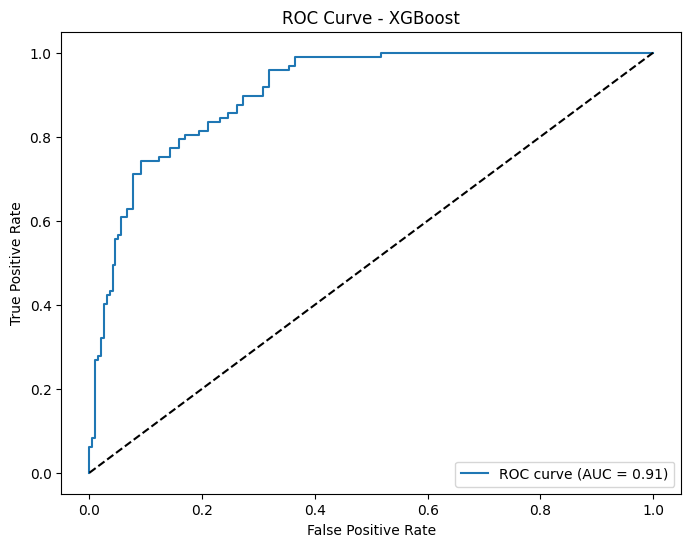


Cross-validation ROC-AUC scores: [0.89801118 0.87362637 0.86385443 0.80306038 0.85334988]
Average CV ROC-AUC: 0.858 (+/- 0.063)


In [3]:
# 2. Model Training dan Evaluasi
print("\n=== Model Training and Evaluation ===")

def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Training
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    print(f"\n{model_name} Results:")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
    print(f"Average CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return model, y_pred, y_pred_proba, cv_scores

# 2.1 Logistic Regression (Baseline)
print("\n=== Training Logistic Regression ===")
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_results = train_evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression")

# 2.2 Random Forest
print("\n=== Training Random Forest ===")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_results = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# 2.3 XGBoost
print("\n=== Training XGBoost ===")
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                             random_state=42)
xgb_results = train_evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")


=== Feature Importance Analysis ===


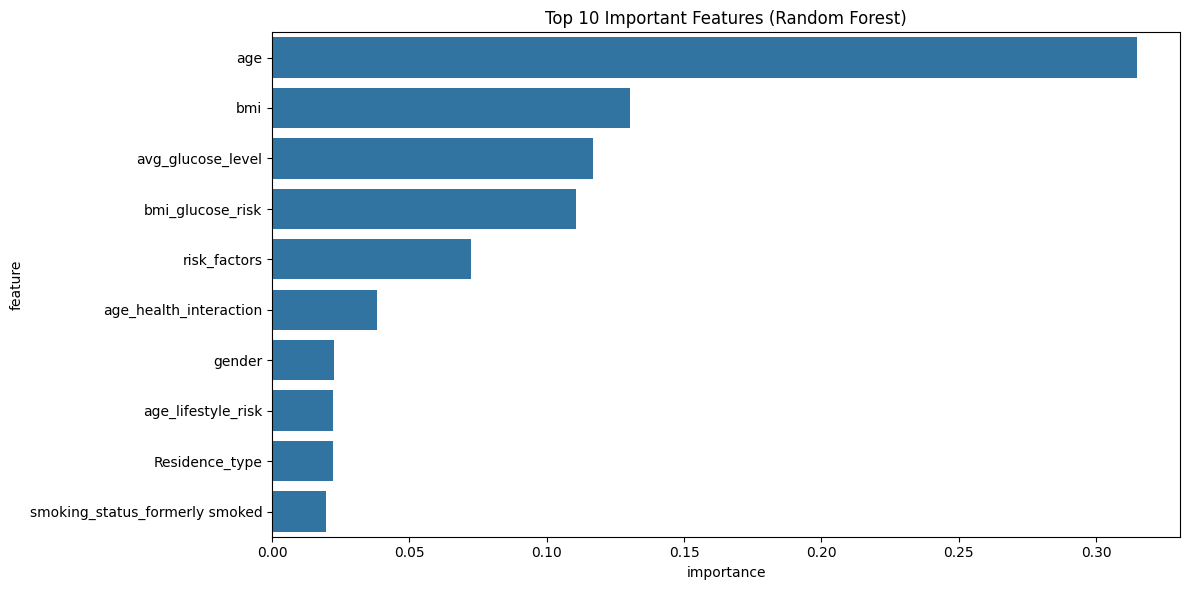

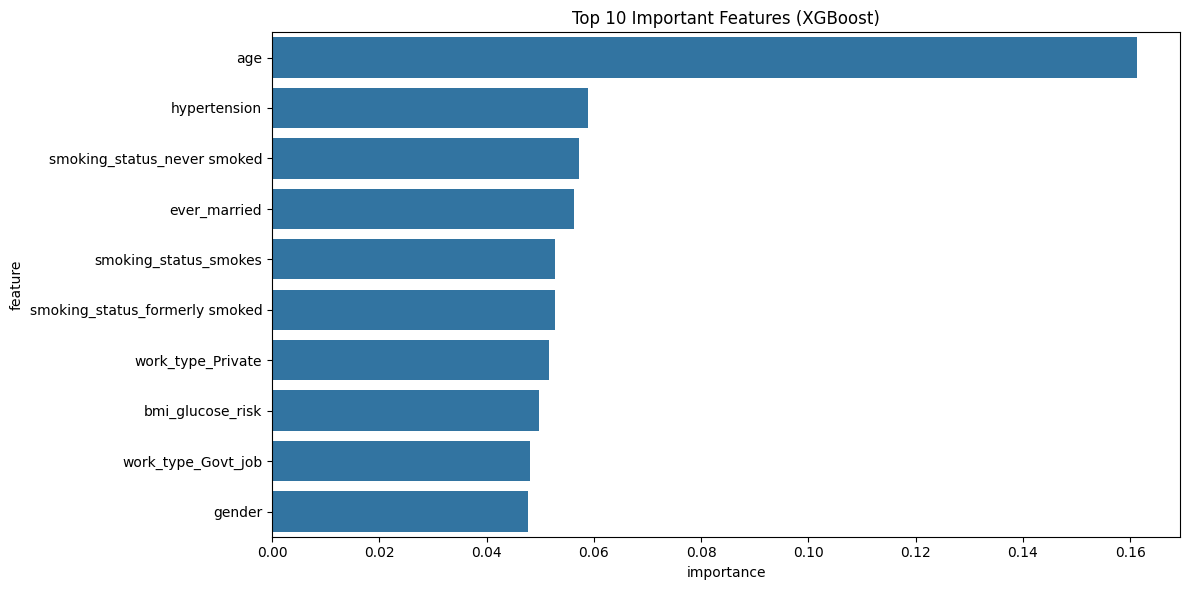

In [4]:
# 3. Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")

# 3.1 Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=rf_importance.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# 3.2 XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=xgb_importance.head(10))
plt.title('Top 10 Important Features (XGBoost)')
plt.tight_layout()
plt.show()


=== Model Comparison ===


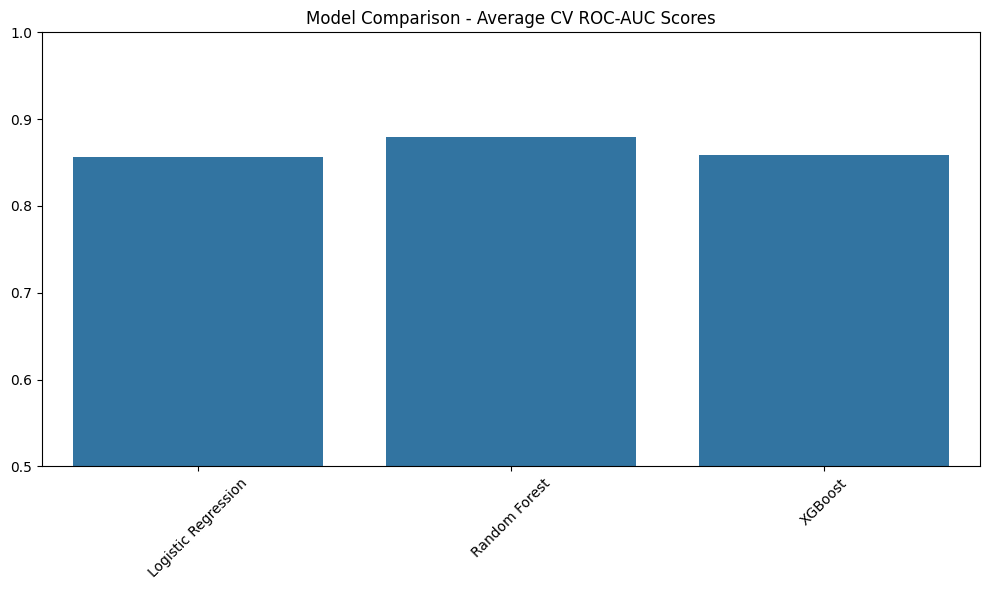

In [5]:
# 4. Model Comparison
print("\n=== Model Comparison ===")
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
cv_scores_all = [
    lr_results[3].mean(),
    rf_results[3].mean(),
    xgb_results[3].mean()
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=cv_scores_all)
plt.title('Model Comparison - Average CV ROC-AUC Scores')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# 5. Save Best Model
print("\n=== Saving Best Model ===")
import joblib

# Tentukan model terbaik berdasarkan CV score
best_score = max(cv_scores_all)
best_model_index = cv_scores_all.index(best_score)
best_model_name = models[best_model_index]

print(f"Best performing model: {best_model_name}")
print(f"Best CV ROC-AUC score: {best_score:.3f}")

# Simpan model terbaik
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = xgb_model

joblib.dump(best_model, '../data/models/best_stroke_model.joblib')
print("Best model saved as 'best_stroke_model.joblib'")


=== Saving Best Model ===
Best performing model: Random Forest
Best CV ROC-AUC score: 0.880
Best model saved as 'best_stroke_model.joblib'



=== Model Optimization ===

=== Random Forest Fine-tuning ===
Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV ROC-AUC score: 0.8836990587300761

=== Ensemble Learning ===

Ensemble Model Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       195
           1       0.72      0.75      0.74        97

    accuracy                           0.82       292
   macro avg       0.80      0.80      0.80       292
weighted avg       0.82      0.82      0.82       292



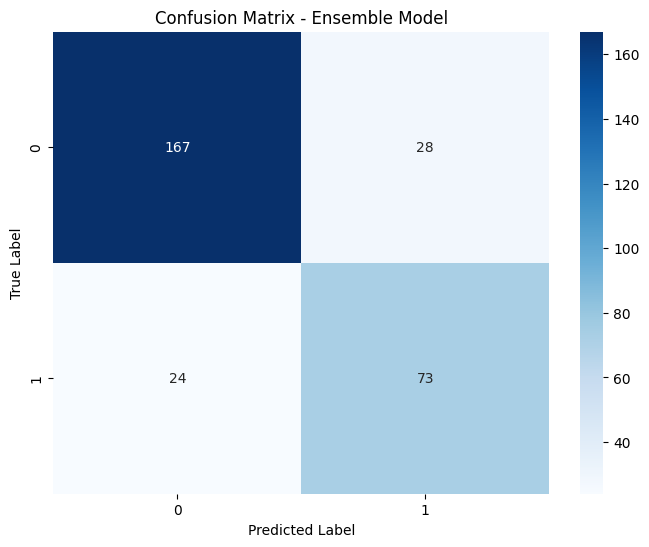

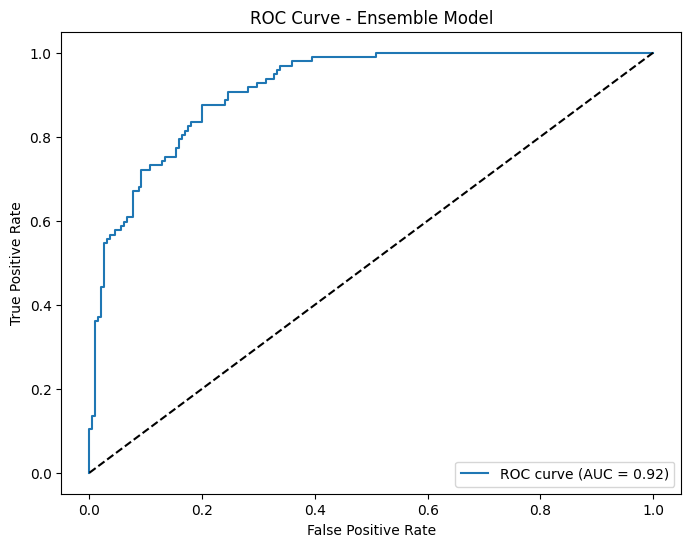


Cross-validation ROC-AUC scores: [0.91469428 0.89452214 0.89602978 0.81091811 0.87733664]
Average CV ROC-AUC: 0.879 (+/- 0.072)

=== Threshold Optimization ===
Optimal threshold: 0.453

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       195
           1       0.76      0.84      0.80        97

    accuracy                           0.86       292
   macro avg       0.84      0.85      0.85       292
weighted avg       0.86      0.86      0.86       292


=== Final Feature Importance Analysis ===


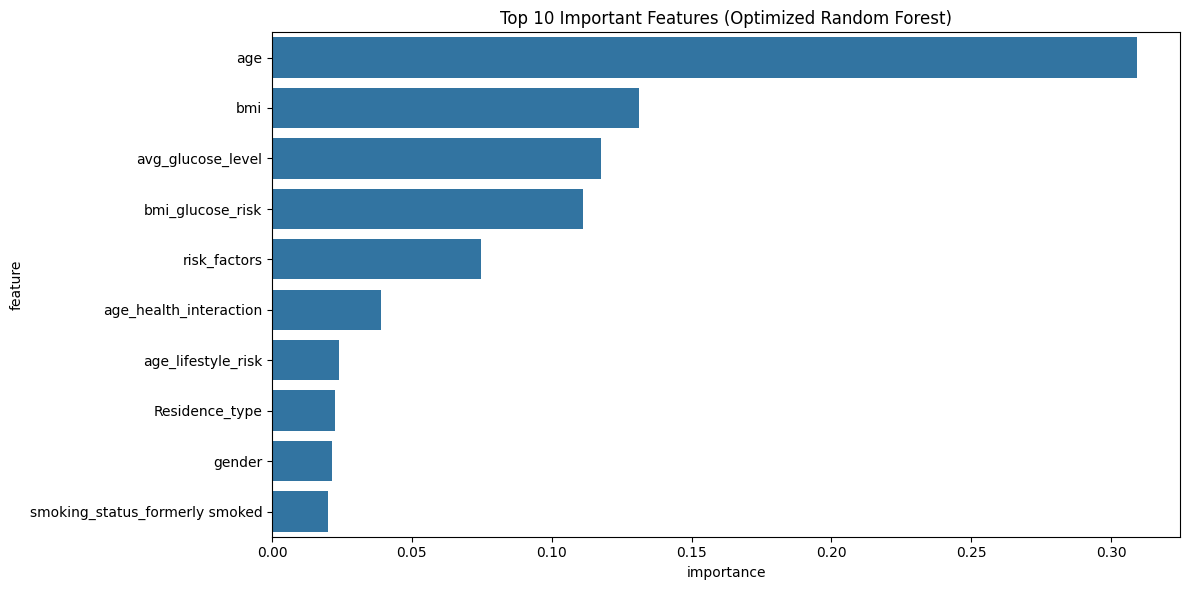


=== Learning Curves Analysis ===


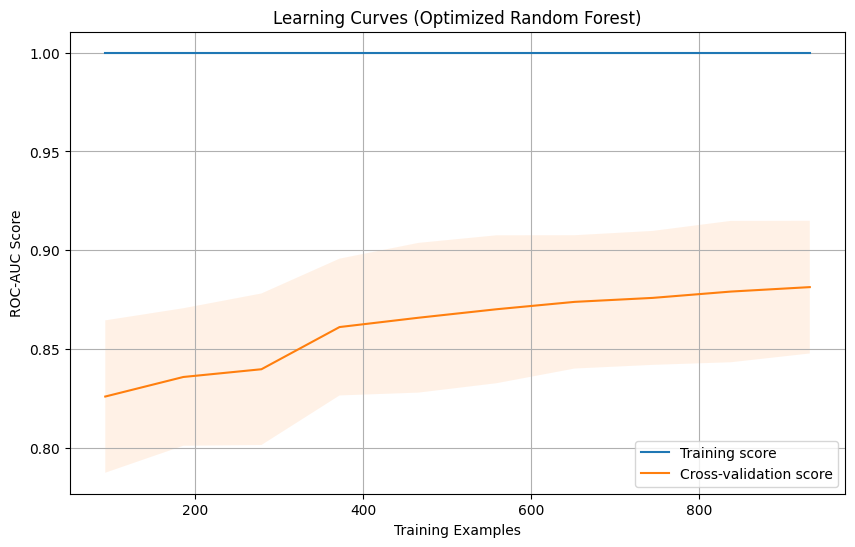


=== Saving Final Results ===
Optimized model and metadata saved successfully

=== Optimization Summary ===
1. Original Random Forest ROC-AUC: 0.8795666815952176
2. Optimized Random Forest ROC-AUC: 0.8836990587300761
3. Ensemble Model ROC-AUC: 0.8787001914545339

Best Parameters for Random Forest:
- class_weight: balanced_subsample
- max_depth: 30
- min_samples_leaf: 1
- min_samples_split: 2
- n_estimators: 300

Optimal Classification Threshold: 0.453


In [10]:
# 5. Model Optimization
print("\n=== Model Optimization ===")

# 5.1 Fine-tuning Random Forest
print("\n=== Random Forest Fine-tuning ===")
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
print("Best parameters:", rf_grid.best_params_)
print("Best CV ROC-AUC score:", rf_grid.best_score_)

# Gunakan model RF terbaik
best_rf = rf_grid.best_estimator_

# 5.2 Ensemble Learning
print("\n=== Ensemble Learning ===")
from sklearn.ensemble import VotingClassifier

# Buat voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', xgb_model),
        ('lr', lr_model)
    ],
    voting='soft'
)

# Evaluasi ensemble model
ensemble_results = train_evaluate_model(
    voting_clf, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    "Ensemble Model"
)

# 5.3 Threshold Optimization
print("\n=== Threshold Optimization ===")
from sklearn.metrics import precision_recall_curve

def find_optimal_threshold(y_true, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

# Gunakan model terbaik untuk threshold optimization
best_proba = best_rf.predict_proba(X_test)[:, 1]
optimal_threshold = find_optimal_threshold(y_test, best_proba)

print(f"Optimal threshold: {optimal_threshold:.3f}")

# Evaluasi dengan threshold optimal
y_pred_optimal = (best_proba >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# 5.4 Feature Importance dari Model Terbaik
print("\n=== Final Feature Importance Analysis ===")
final_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=final_importance.head(10))
plt.title('Top 10 Important Features (Optimized Random Forest)')
plt.tight_layout()
plt.show()

# 5.5 Learning Curves
print("\n=== Learning Curves Analysis ===")
from sklearn.model_selection import learning_curve

def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('ROC-AUC Score')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curves(best_rf, X_train, y_train, 'Learning Curves (Optimized Random Forest)')

# 5.6 Save Final Model and Results
print("\n=== Saving Final Results ===")
import joblib

# Save optimized model
joblib.dump(best_rf, '../data/models/optimized_stroke_model.joblib')

# Save model metadata
model_metadata = {
    'original_performance': {
        'lr': cv_scores_all[0],
        'rf': cv_scores_all[1],
        'xgb': cv_scores_all[2]
    },
    'optimized_performance': {
        'best_params': rf_grid.best_params_,
        'best_score': rf_grid.best_score_,
        'optimal_threshold': optimal_threshold
    },
    'feature_importance': final_importance.to_dict()
}

joblib.dump(model_metadata, '../data/models/model_metadata.joblib')
print("Optimized model and metadata saved successfully")

# 5.7 Final Summary
print("\n=== Optimization Summary ===")
print("1. Original Random Forest ROC-AUC:", cv_scores_all[1])
print("2. Optimized Random Forest ROC-AUC:", rf_grid.best_score_)
print("3. Ensemble Model ROC-AUC:", np.mean(ensemble_results[3]))
print("\nBest Parameters for Random Forest:")
for param, value in rf_grid.best_params_.items():
    print(f"- {param}: {value}")
print(f"\nOptimal Classification Threshold: {optimal_threshold:.3f}")

In [8]:
# 6. Summary
print("\n=== Training Summary ===")
print("1. Models trained:")
for model, score in zip(models, cv_scores_all):
    print(f"   - {model}: CV ROC-AUC = {score:.3f}")
    
print("\n2. Best model:", best_model_name)
print(f"3. Best CV ROC-AUC score: {best_score:.3f}")
print("\n4. Next steps recommendation:")
print("   - Fine-tune the best model using GridSearchCV")
print("   - Try ensemble methods combining multiple models")
print("   - Collect more data if possible")
print("   - Consider feature selection based on importance analysis")


=== Training Summary ===
1. Models trained:
   - Logistic Regression: CV ROC-AUC = 0.856
   - Random Forest: CV ROC-AUC = 0.880
   - XGBoost: CV ROC-AUC = 0.858

2. Best model: Random Forest
3. Best CV ROC-AUC score: 0.880

4. Next steps recommendation:
   - Fine-tune the best model using GridSearchCV
   - Try ensemble methods combining multiple models
   - Collect more data if possible
   - Consider feature selection based on importance analysis
